In [3]:
# 下面代码的使用的目的是为了将EEGNet导入进来
import sys
sys.path.append(r'D:\AI\Python\Work\EEGNet-TensorFlow\arl-eegmodels-master')

import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

K.set_image_data_format('channels_first')


# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt


In [4]:
##################### Process, filter and epoch the data ######################
# data_path = sample.data_path()
data_path = "E:/MNE-sample-data"

# Set parameters and read data
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data() * 1000  # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151

# take 50/25/25 percent of the data to train/validate/test
X_train = X[0:144, ]
Y_train = y[0:144]
X_validate = X[144:216, ]
Y_validate = y[144:216]
X_test = X[216:, ]
Y_test = y[216:]



In [5]:
############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train = np_utils.to_categorical(Y_train - 1)
Y_validate = np_utils.to_categorical(Y_validate - 1)
Y_test = np_utils.to_categorical(Y_test - 1)

# convert data to NCHW (trials, kernels, channels, samples) format. Data
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
X_validate = X_validate.reshape(X_validate.shape[0], kernels, chans, samples)
X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes=4, Chans=chans, Samples=samples,
               dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16,
               dropoutType='Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# count number of parameters in the model
numParams = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)


X_train shape: (144, 1, 60, 151)
144 train samples
72 test samples


In [6]:
###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during
# optimization to balance it out. This data is approximately balanced so we
# don't need to do this, but is shown here for illustration/completeness.
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0: 1, 1: 1, 2: 1, 3: 1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN +
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size=16, epochs=300,
                        verbose=2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight=class_weights)

# load optimal weights
model.load_weights('/tmp/checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

# WEIGHTS_PATH = /path/to/EEGNet-8-2-weights.h5
# model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs = model.predict(X_test)
preds = probs.argmax(axis=-1)
acc = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

W0617 11:46:52.890793  4932 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0617 11:46:52.907747  4932 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train on 144 samples, validate on 72 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 1.38628, saving model to /tmp/checkpoint.h5
144/144 - 2s - loss: 1.4201 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2639
Epoch 2/300

Epoch 00002: val_loss did not improve from 1.38628
144/144 - 0s - loss: 1.3680 - accuracy: 0.3681 - val_loss: 1.3863 - val_accuracy: 0.2361
Epoch 3/300

Epoch 00003: val_loss did not improve from 1.38628
144/144 - 0s - loss: 1.3541 - accuracy: 0.3681 - val_loss: 1.3864 - val_accuracy: 0.2361
Epoch 4/300

Epoch 00004: val_loss did not improve from 1.38628
144/144 - 0s - loss: 1.3341 - accuracy: 0.4306 - val_loss: 1.3863 - val_accuracy: 0.2361
Epoch 5/300

Epoch 00005: val_loss did not improve from 1.38628
144/144 - 0s - loss: 1.3186 - accuracy: 0.4514 - val_loss: 1.3863 - val_accuracy: 0.2361
Epoch 6/300

Epoch 00006: val_loss did not improve from 1.38628
144/144 - 0s - loss: 1.2847 - accuracy: 0.4931 - val_loss: 1.3863 - val_accuracy: 0.2361
E

Classification accuracy: 0.944444 


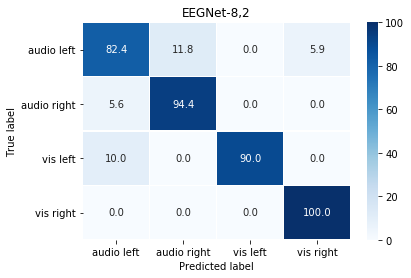

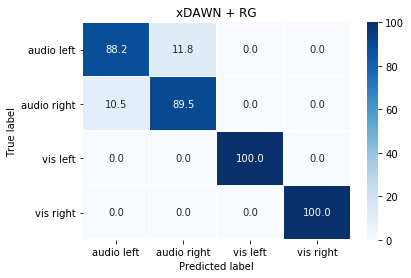

In [7]:
############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in
# the tangent space with a logistic regression

n_components = 2  # pick some components

# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train = X_train.reshape(X_train.shape[0], chans, samples)
X_test = X_test.reshape(X_test.shape[0], chans, samples)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train.argmax(axis=-1))
preds_rg = clf.predict(X_test)

# Printing the results
acc2 = np.mean(preds_rg == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc2))

# plot the confusion matrices for both classifiers
names = ['audio left', 'audio right', 'vis left', 'vis right']
plt.figure(0)
plot_confusion_matrix(preds, Y_test.argmax(axis=-1), names, title='EEGNet-8,2')

plt.figure(1)
plot_confusion_matrix(preds_rg, Y_test.argmax(axis=-1), names, title='xDAWN + RG')

